In [38]:
%pip install HanTa
%pip install lda
%pip install pyldavis
%pip install germalemma==0.1.3

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import lda
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from HanTa import HanoverTagger as ht
from nltk.corpus import stopwords
from germalemma import GermaLemma
import pyLDAvis.gensim_models
import pyLDAvis
pyLDAvis.enable_notebook()

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
en_tagger = ht.HanoverTagger('morphmodel_en.pgz')
de_tagger = ht.HanoverTagger('morphmodel_ger.pgz')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Moinam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Moinam\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Moinam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Moinam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
def clean_data():
    def remove_emojis(data):
        emoj = re.compile("["
                          u"\U0001F600-\U0001F64F"  # emoticons
                          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                          u"\U0001F680-\U0001F6FF"  # transport & map symbols
                          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          u"\U00002500-\U00002BEF"  # chinese char
                          u"\U00002702-\U000027B0"
                          u"\U00002702-\U000027B0"
                          u"\U000024C2-\U0001F251"
                          u"\U0001f926-\U0001f937"
                          u"\U00010000-\U0010ffff"
                          u"\u2640-\u2642"
                          u"\u2600-\u2B55"
                          u"\u200d"
                          u"\u23cf"
                          u"\u23e9"
                          u"\u231a"
                          u"\ufe0f"  # dingbats
                          u"\u3030"
                          "]+", re.UNICODE)
        return re.sub(emoj, '', data)

    # Removing mentions and hashtags and url
    def remove_mentions_and_tags(text):
        text = re.sub(r'@\S*', '', text)
        text = re.sub(r'http\S+', '', text)
        return re.sub(r'#\S*', '', text)

    read_df = pd.read_parquet('twitter_data.parquet')
    read_df = read_df.drop_duplicates(subset=['tweet_id'])
    read_df = read_df.loc[read_df['tweet_type'] != 'retweet']
    read_df.text = read_df.text.apply(remove_emojis)
    read_df.text = read_df.text.apply(remove_mentions_and_tags)
    read_df['text'] = read_df['text'].str.replace(
        r'[^\w\s]+', '')  # remove punctuations
    read_df['text'] = read_df['text'].str.replace('\d+', '')  # removes number
    en_df = read_df[read_df.tweet_language == 'en']
    de_df = read_df[read_df.tweet_language == 'de']
    return en_df, de_df, read_df

def extract_adj_noun(df, tagger: ht.HanoverTagger, lang: str):

  def noun(text, tagger):
    words = nltk.word_tokenize(text)
    tokens = [word for (word, x, pos) in tagger.tag_sent(
        words, taglevel=1) if pos == 'NN']
    return tokens

  def adj(text, tagger):
    words = nltk.word_tokenize(text)
    tokens = [word for (word, x, pos) in tagger.tag_sent(
        words, taglevel=1) if pos == 'ADJ']
    return tokens

  def to_lowercase(text):
    token = []
    for i in range(len(text)):
      val = text[i].lower()
      token.append(val)
    return token

  def stop_word_removal(x, stop_words):
    return ' '.join([w for w in x if not w in stop_words])

  df['noun'] = df.text.apply(noun, tagger=tagger)
  df['adj'] = df.text.apply(adj, tagger=tagger)
  df.noun = df.noun.apply(to_lowercase)
  stop_words = stopwords.words(lang)
  stop_words.append('amp')
  df.noun = df.noun.apply(stop_word_removal, stop_words=stop_words)
  df.adj = df.adj.apply(stop_word_removal, stop_words=stop_words)
  return df


def lementize_en_text(df):
  w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
  lemmatizer = nltk.stem.WordNetLemmatizer()

  def lemmatize_text(text):
    return [lemmatizer.lemmatize(w, 'n') for w in w_tokenizer.tokenize(text)]

  def lemmatize_text_adj(text):
    return [lemmatizer.lemmatize(w, 'a') for w in w_tokenizer.tokenize(text)]

  df['lemma_noun'] = df.noun.apply(lemmatize_text)
  df['lemma_adj'] = df.adj.apply(lemmatize_text_adj)
  dict_docs = df.lemma_noun.to_dict()
  return df, dict_docs


def lementize_de_text(df):
  lemmatizer = GermaLemma()

  def lemmatize_noun(x):
    arr = []
    token = x.split()
    for i in range(len(token)):
      lemma_noun = lemmatizer.find_lemma(token[i], 'N')
      arr.append(lemma_noun)
    return arr

  def lemmatize_adj(x):
    arr = []
    token = x.split()
    for i in range(len(token)):
      lemma_noun = lemmatizer.find_lemma(token[i], 'ADJ')
      arr.append(lemma_noun)
    return arr

  df['lemma_noun'] = df.noun.apply(lemmatize_noun)
  df['lemma_adj'] = df.adj.apply(lemmatize_adj)
  dict_docs = df.lemma_noun.to_dict()
  return df, dict_docs


def lda_topic_model(df):

  def generate_tokens(tweet):
    words = []
    for i in range(len(tweet)):
      word = tweet[i]
    # using the if condition because we introduced extra spaces during text cleaning
      if word != '':
        words.append(word)
    return words

  def create_dictionary(words):
    return corpora.Dictionary(words)

  def create_document_matrix(tokens, id2word):
    corpus = []
    for text in tokens:
      corpus.append(id2word.doc2bow(text))
    return corpus

  #storing the generated tokens in a new column named 'words'
  df['tokens'] = df.lemma_noun.apply(generate_tokens)

  #passing the dataframe column having tokens as the argument
  id2word = create_dictionary(df.tokens)

  #passing the dataframe column having tokens and dictionary
  corpus = create_document_matrix(df.tokens, id2word)
  return corpus, id2word


def fetch_doc_topic(df, corpus, lda_model, ntopics):
    def get_doc_topic(corpus, model):
        doc_topic = []
        for doc in range(len(corpus)):
            try:
                doc_topic.append(
                    {'Tweet': df.iloc[doc].text, 'Hashtags': df.iloc[doc].hashtags, 'Topic_Probability': model.__getitem__(corpus[doc], eps=0)})
            except Exception as e:
                print(e)
        return doc_topic

    def calc_doc_topic_count(doc_topic, count_arr):
        for topic in doc_topic:
            prob = topic['Topic_Probability']
            big = -99999
            for p in prob:
                if p[1] > big:
                    big = p[1]
                    max_top = p[0]
            count_arr[max_top] += 1
        return count_arr

    doc_topic = get_doc_topic(corpus, lda_model)
    doc_topic_df = pd.DataFrame(doc_topic)
    count_arr = calc_doc_topic_count(doc_topic, [0]*ntopics)
    return doc_topic, doc_topic_df, count_arr


def doc_topic_pie_chart(ntopics, count_arr):
    topics = []
    for i in range(ntopics):
        topics.append(i+1)
    plt.figure(figsize=(8, 8))
    plt.pie(count_arr, labels=topics,
            autopct='%1.1f%%', textprops={'fontsize': 18})
    plt.title('Tweets distribution in topics', fontsize=20)
    #plt.legend(data_pie.tweets_count,fontsize=20)
    plt.show()


def print_beauty(df, word_topic_df):
    for i in range(6, 10):
        print('Tweet:', df.iloc[i].Tweet)
        print('Hashtags:', df.iloc[i].Hashtags)
        print('Topic_Probability:', df.iloc[i].Topic_Probability)
        print("----------------------------------------------------------------\n")

    for i in range(4):
        print("Topic ", (i+1))
        print("Most Probable Word List: ",
              word_topic_df.iloc[i].most_prob_words)
        print("-------------------------------------------------------\n")


def fetch_word_topic(lda_model, id2word):
    def get_topic_to_wordids(model):
        p = list()
        for topicid in range(model.num_topics):
            topic = model.state.get_lambda()[topicid]
            topic = topic / max(topic)  # normalize to probability dist
            p.append(topic)
        return p

    def create_dict_word_topic(id2word, word_topic):
        word_topic_dict = []
        i = 0
        for topic in word_topic:
            prob_words = []
            for word_ind in range(len(topic)):
                if (topic[word_ind] >= 0.15):
                    prob_words.append(id2word[word_ind])
            word_topic_dict.append(
                {'Topic': (i+1), 'most_prob_words': prob_words})
            i += 1
        return word_topic_dict

    word_topic = get_topic_to_wordids(lda_model)
    word_topic_dict = create_dict_word_topic(id2word, word_topic)
    word_topic_df = pd.DataFrame(word_topic_dict)
    return word_topic_dict, word_topic_df


<>:38: DeprecationWarning: invalid escape sequence '\d'
<>:38: DeprecationWarning: invalid escape sequence '\d'
C:\Users\Moinam\AppData\Local\Temp\ipykernel_9408\366944591.py:38: DeprecationWarning: invalid escape sequence '\d'
  read_df['text'] = read_df['text'].str.replace('\d+', '')  # removes number


In [41]:
en_topics = 4
de_topics = 5

def run(df, tagger: ht.HanoverTagger, language: str, n_topics: int):
    df = extract_adj_noun(en_df, tagger, language)
    if language == "english":
        df, dict_docs = lementize_en_text(df)
    else:
        df, dict_docs = lementize_de_text(df)
    corpus, id2word = lda_topic_model(df)
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus, id2word=id2word, num_topics=n_topics, random_state=42)
    doc_topic, doc_topic_df, count_arr = fetch_doc_topic(
        df, corpus, lda_model, n_topics)
    word_topic_dict, word_topic_df = fetch_word_topic(lda_model, id2word)
    return df, dict_docs, corpus, id2word, lda_model, doc_topic, doc_topic_df, count_arr, word_topic_dict, word_topic_df


en_df, de_df, read_df = clean_data()

C:\Users\Moinam\AppData\Local\Temp\ipykernel_9408\366944591.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  read_df['text'] = read_df['text'].str.replace(
C:\Users\Moinam\AppData\Local\Temp\ipykernel_9408\366944591.py:38: FutureWarning: The default value of regex will change from True to False in a future version.
  read_df['text'] = read_df['text'].str.replace('\d+', '')  # removes number


In [42]:
en_df.head()

,timestamp,tweet_id,conversation_id,author_id,text,retweet_count,reply_count,like_count,quote_count,referenced_tweets,hashtags,tweet_type,tweet_language
11,2021-06-18T13:10:36.000Z,1405875593711964166,1405875593711964166,1132055796571877376,Thread about the cruel in German The debate...,5,0,19,0,"[{'type': 'quoted', 'id': '1405846267759054851'}]","['precarity', 'academia', 'IchbinHanna', 'Acad...",original,en
105,2021-06-12T21:15:23.000Z,1403823267115376649,1403823267115376649,1132055796571877376,Thread summarizing a video by the German Fede...,1,0,9,1,"[{'type': 'quoted', 'id': '1403006909079293953'}]","['IchbinHanna', 'academia', 'Germany', 'toxica...",original,en
125,2021-06-11T22:32:52.000Z,1403480380632674307,1403480380632674307,1132055796571877376,On job in German and its impact on life and...,0,0,1,0,"[{'type': 'quoted', 'id': '1402963684691955714'}]","['precarity', 'academia', 'family', 'mentalhea...",original,en
215,2021-06-10T19:07:52.000Z,1403066401611472902,1403066401611472902,1132055796571877376,,0,0,1,0,"[{'type': 'quoted', 'id': '1403059508021284864'}]","['AcademicTwitter', 'acertaindegreeofflexibili...",original,en
238,2021-06-10T15:04:44.000Z,1403005214974640143,1403005214974640143,1132055796571877376,German researchers without a permanent post i...,7,0,15,0,"[{'type': 'quoted', 'id': '1402994337009442820'}]","['IchbinHanna', 'academia', 'AcademicTwitter',...",original,en


In [43]:
de_df.head()

,timestamp,tweet_id,conversation_id,author_id,text,retweet_count,reply_count,like_count,quote_count,referenced_tweets,hashtags,tweet_type,tweet_language
1,2021-06-20T21:29:24.000Z,1406725899744157698,1406725899744157698,2981738470,Wenn Wirtschaftsjounalistinnen über schreiben...,9,1,62,4,[],['IchbinHanna'],original,de
16,2021-06-18T10:21:31.000Z,1405833045224087555,1405833045224087555,242424959,Liebe und Forsa schön dass ihr euch per Umfr...,0,1,2,0,[],"['Mittelbau', 'IchBinHanna']",original,de
19,2021-06-18T08:35:29.000Z,1405806358335832065,1405806358335832065,1132055796571877376,Wichtiger Thread zu in der der durch die A...,2,0,13,0,"[{'type': 'quoted', 'id': '1405494574533984264'}]","['Machtmissbrauch', 'Wissenschaft', 'prekär', ...",original,de
21,2021-06-18T07:52:36.000Z,1405795569273131011,1405795569273131011,1132055796571877376,Wir können ja mal einen für machen Wer macht...,4,0,16,0,"[{'type': 'quoted', 'id': '1405617868734148610'}]","['FollowFriday', 'IchbinHanna', 'WissZeitVG', ...",original,de
22,2021-06-18T02:42:56.000Z,1405717636999155717,1405717636999155717,2981738470,Das ist übrigens ein Punkt der mir bei einfac...,1,0,6,0,"[{'type': 'quoted', 'id': '1405460325437149186'}]",['IchbinHanna'],original,de


In [44]:
en_df, en_dict_docs, en_corpus, en_id2word, en_lda_model, en_doc_topic, en_doc_topic_df, en_count_arr, en_word_topic_dict, en_word_topic_df = run(
    en_df, en_tagger, "english", en_topics)

de_df, de_dict_docs, de_corpus, de_id2word, de_lda_model, de_doc_topic, de_doc_topic_df, de_count_arr, de_word_topic_dict, de_word_topic_df = run(
    de_df, de_tagger, "german", de_topics)

C:\Users\Moinam\AppData\Local\Temp\ipykernel_9408\366944591.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['noun'] = df.text.apply(noun, tagger=tagger)
C:\Users\Moinam\AppData\Local\Temp\ipykernel_9408\366944591.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['adj'] = df.text.apply(adj, tagger=tagger)
C:\Users\Moinam\AppData\Local\Temp\ipykernel_9408\366944591.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [ ]:
en_df.head()

In [11]:
de_df.head()

,timestamp,tweet_id,conversation_id,author_id,text,retweet_count,reply_count,like_count,quote_count,referenced_tweets,hashtags,tweet_type,tweet_language,noun,adj
1,2021-06-20T21:29:24.000Z,1406725899744157698,1406725899744157698,2981738470,Wenn Wirtschaftsjounalistinnen über schreiben...,9,1,62,4,[],['IchbinHanna'],original,de,wirtschaftsjounalistinnen geschichten nachwuch...,
16,2021-06-18T10:21:31.000Z,1405833045224087555,1405833045224087555,242424959,Liebe und Forsa schön dass ihr euch per Umfr...,0,1,2,0,[],"['Mittelbau', 'IchBinHanna']",original,de,liebe forsa umfrage fragen entfristung planbar...,
19,2021-06-18T08:35:29.000Z,1405806358335832065,1405806358335832065,1132055796571877376,Wichtiger Thread zu in der der durch die A...,2,0,13,0,"[{'type': 'quoted', 'id': '1405494574533984264'}]","['Machtmissbrauch', 'Wissenschaft', 'prekär', ...",original,de,thread arbeitsverträge,
21,2021-06-18T07:52:36.000Z,1405795569273131011,1405795569273131011,1132055796571877376,Wir können ja mal einen für machen Wer macht...,4,0,16,0,"[{'type': 'quoted', 'id': '1405617868734148610'}]","['FollowFriday', 'IchbinHanna', 'WissZeitVG', ...",original,de,,
22,2021-06-18T02:42:56.000Z,1405717636999155717,1405717636999155717,2981738470,Das ist übrigens ein Punkt der mir bei einfac...,1,0,6,0,"[{'type': 'quoted', 'id': '1405460325437149186'}]",['IchbinHanna'],original,de,punkt verwertungslogik bekenntnisse ausschreib...,


In [15]:
def create_doc_count_vector(df):
    vect = CountVectorizer()
    vects = vect.fit_transform(df.noun)
    newdf = pd.DataFrame(vects.todense())
    newdf.columns = vect.get_feature_names()
    tdm = newdf.T
    tdm.columns = ['Doc '+str(i) for i in range(newdf.shape[0])]
    tdm['total_count'] = tdm.sum(axis=1)
    tdm = tdm.sort_values(by='total_count', ascending=False)
    tdm = tdm.drop(columns=['total_count'], axis=1)
    dtm = tdm.to_numpy()
    return tdm, dtm

# en_tdm, en_dtm = create_doc_count_vector(en_df)
# de_tdm, de_dtm = create_doc_count_vector(de_df)

c:\Users\Moinam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Moinam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


INFO:lda:n_documents: 3655
INFO:lda:vocab_size: 6129
INFO:lda:n_words: 24949
INFO:lda:n_topics: 2
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -267998
INFO:lda:<10> log likelihood: -237173
INFO:lda:<20> log likelihood: -236434
INFO:lda:<30> log likelihood: -235978
INFO:lda:<40> log likelihood: -235969
INFO:lda:<50> log likelihood: -235669
INFO:lda:<60> log likelihood: -235641
INFO:lda:<70> log likelihood: -235479
INFO:lda:<80> log likelihood: -235501
INFO:lda:<90> log likelihood: -235255
INFO:lda:<100> log likelihood: -235266
INFO:lda:<110> log likelihood: -235215
INFO:lda:<120> log likelihood: -235273
INFO:lda:<130> log likelihood: -235028
INFO:lda:<140> log likelihood: -234838
INFO:lda:<150> log likelihood: -234816
INFO:lda:<160> log likelihood: -234830
INFO:lda:<170> log likelihood: -234792
INFO:lda:<180> log likelihood: -234790
INFO:lda:<190> log likelihood: -234611
INFO:lda:<200> log likelihood: -234618
INFO:lda:<210> log likelihood: -234674
INFO:lda:<220> log likelihood: -2

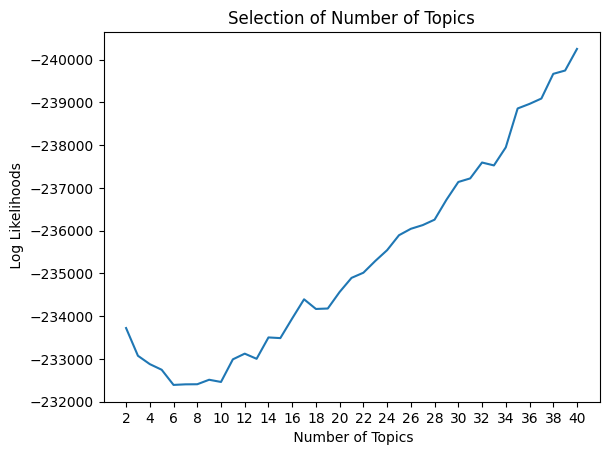

In [17]:
def lda_topic_model_search(dtm, n_topics):
    log_likelihoods = []
    lda_models = []

    for i in n_topics:
        tdm_lda = lda.LDA(n_topics=i, n_iter=1000, random_state=42)
        tdm_lda.fit(dtm)
        log_likelihoods.append(tdm_lda.loglikelihoods_[99])
        lda_models.append(tdm_lda)
    return log_likelihoods, lda_models

def create_plot(n_topics, log_like):
    plt.plot(n_topics, log_like)
    plt.xticks(np.arange(min(n_topics), max(n_topics)+1, 2))
    plt.gca().invert_yaxis()
    plt.title('Selection of Number of Topics')
    plt.xlabel(' Number of Topics')
    plt.ylabel(' Log Likelihoods')
    plt.show()

n_topics = []
for i in range(2, 41):
    n_topics.append(i)

# en_log_like, en_lda = lda_topic_model_search(dtm=en_dtm, n_topics=n_topics)
# de_log_like, de_lda = lda_topic_model_search(dtm=de_dtm, n_topics=n_topics)

# create_plot(n_topics, en_log_like)

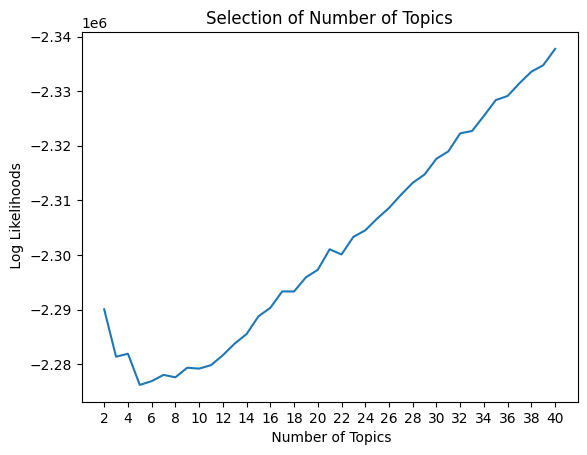

In [18]:
# create_plot(n_topics, de_log_like)

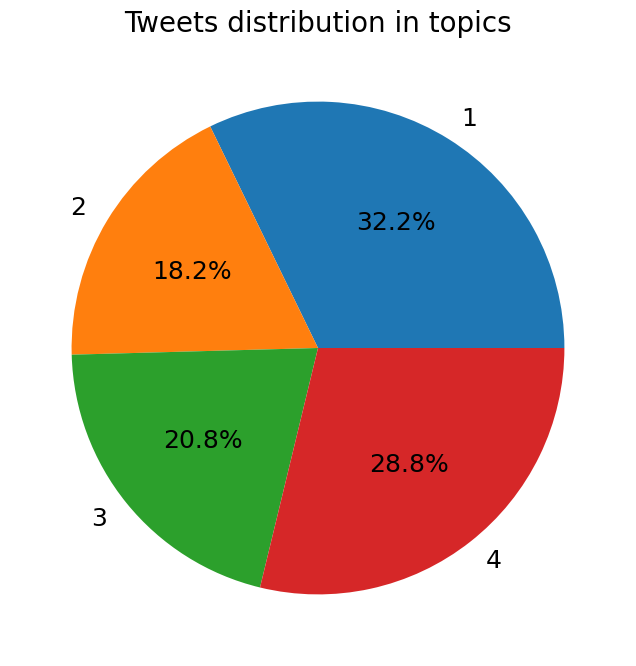

In [45]:
doc_topic_pie_chart(en_topics, en_count_arr)

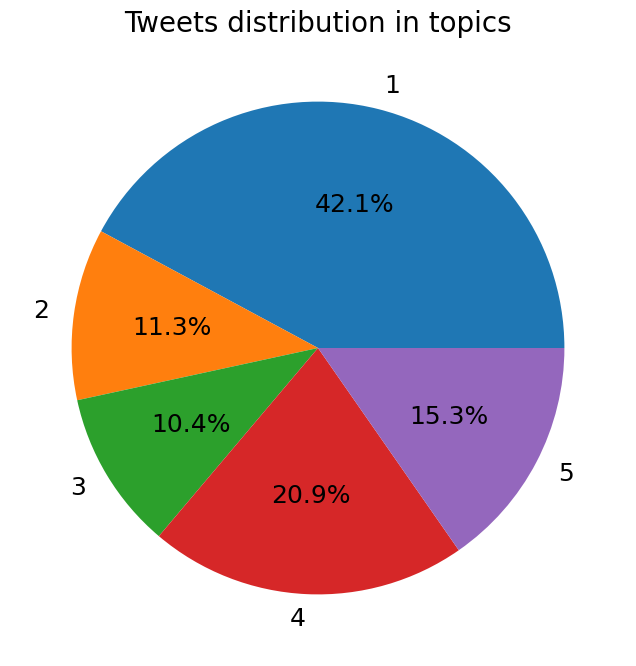

In [46]:
doc_topic_pie_chart(de_topics, de_count_arr)

In [47]:
print_beauty(en_doc_topic_df, en_word_topic_df)


Tweet: Like so many  Ive learned that I am a good enough researcher to stay in academia but what the  does is not to select the best candidates It also does not train researchers to become the best candidates deserving of permanent jobs
Hashtags: ['IchbinHanna', 'WissZeitVG']
Topic_Probability: [(0, 0.35916924), (1, 0.085244715), (2, 0.46850178), (3, 0.08708428)]
----------------------------------------------------------------

Tweet: For those who dont read German

The response by the ministry of education to the outpouring of stories and discussions regarding academic precarity  is unbelievably patronising and disrespectful
Hashtags: ['IchBinHanna']
Topic_Probability: [(0, 0.04297296), (1, 0.042300906), (2, 0.045084942), (3, 0.8696412)]
----------------------------------------------------------------

Tweet: So  proudly explains the advantages of the  to early carrer researchers as if they were preschool children This law is a great obstacle to many brilliant young minds and threaten

In [48]:
print_beauty(de_doc_topic_df, de_word_topic_df)


Tweet: Like so many  Ive learned that I am a good enough researcher to stay in academia but what the  does is not to select the best candidates It also does not train researchers to become the best candidates deserving of permanent jobs
Hashtags: ['IchbinHanna', 'WissZeitVG']
Topic_Probability: [(0, 0.050027315), (1, 0.050011177), (2, 0.05024836), (3, 0.55718887), (4, 0.2925243)]
----------------------------------------------------------------

Tweet: For those who dont read German

The response by the ministry of education to the outpouring of stories and discussions regarding academic precarity  is unbelievably patronising and disrespectful
Hashtags: ['IchBinHanna']
Topic_Probability: [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0.2)]
----------------------------------------------------------------

Tweet: So  proudly explains the advantages of the  to early carrer researchers as if they were preschool children This law is a great obstacle to many brilliant young minds and threatens 

In [49]:
vis = pyLDAvis.gensim_models.prepare(en_lda_model,
                                     en_corpus,
                                     dictionary=en_lda_model.id2word)
vis

c:\Users\Moinam\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.079702  0.016850       1        1  30.986551
2     -0.098173 -0.132742       2        1  25.045114
0     -0.019263  0.159590       3        1  23.928725
1      0.197138 -0.043698       4        1  20.039610, topic_info=           Term        Freq       Total Category  logprob  loglift
955       music  212.000000  212.000000  Default  30.0000  30.0000
957       click  185.000000  185.000000  Default  29.0000  29.0000
1        thread  204.000000  204.000000  Default  28.0000  28.0000
31       system  348.000000  348.000000  Default  27.0000  27.0000
20     academia  637.000000  637.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
257         day   34.637111  110.461771   Topic4  -4.9780   0.4477
7      research   43.578096  335.029295   Topic4  -4.7484  -0.4322
85         work   39.334449  227.914932   Topic4  -4.8508  -0.1494
181   professor   29.592684  118.053864   Topic4  -5.1354   0.2238
430  experience   25.843871   59.909917   Topic4  -5.2709   0.7667

[259 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
20        1  0.298217  academia
20        2  0.069061  academia
20        3  0.517956  academia
20        4  0.113009  academia
1006      3  0.972348     admin
...     ...       ...       ...
35        1  0.606435      year
35        2  0.079414      year
35        3  0.295998      year
35        4  0.021658      year
700       3  0.913203     youve

[495 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

In [50]:
vis = pyLDAvis.gensim_models.prepare(de_lda_model,
                                     de_corpus,
                                     dictionary=de_lda_model.id2word)
vis

c:\Users\Moinam\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.178679 -0.091725       1        1  28.674720
4     -0.188005  0.152151       2        1  20.571789
1      0.166344  0.131878       3        1  17.878764
0      0.145158  0.009896       4        1  16.772163
2      0.055182 -0.202200       5        1  16.102565, topic_info=            Term        Freq       Total Category  logprob  loglift
6            Not  632.000000  632.000000  Default  30.0000  30.0000
98          Been  210.000000  210.000000  Default  29.0000  29.0000
32          Here  312.000000  312.000000  Default  28.0000  28.0000
51      Position  168.000000  168.000000  Default  27.0000  27.0000
48         These  226.000000  226.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
27           See   23.514324  111.436999   Topic5  -4.1333   0.2703
255  Information   10.130857   19.503381   Topic5  -4.9754   1.1712
184            a   10.905621   30.255658   Topic5  -4.9017   0.8058
80          Sure   12.369689   86.296970   Topic5  -4.7757  -0.1164
9      Positions   13.036434  139.738654   Topic5  -4.7232  -0.5458

[252 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
813       1  0.213863    Agenda
813       4  0.748521    Agenda
236       1  0.083713  Argument
236       2  0.055809  Argument
236       4  0.837129  Argument
...     ...       ...       ...
272       3  0.060362  Workshop
334       2  0.854653     Would
375       2  0.982252   Youtube
184       3  0.627982         a
184       5  0.363568         a

[416 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 1, 3])